<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/Clipping%20Raster%20In%20R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clip Raster in R
#### https://www.earthdatascience.org/courses/earth-analytics/lidar-raster-data-r/crop-raster-data-in-r/

In [1]:
# load the raster and rgdal libraries
install.packages("raster")
install.packages("rgdal")
install.packages("googledrive")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘Rcpp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘rgdal’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# install.packages('sf')
# install.packages('exactextractr')
# install.packages("DBI")
# install.packages("RSQLite")
# install.packages("RPostgreSQL")

In [3]:
library(ggplot2)
# library(sf)
library(magrittr)
library(data.table)
library(raster)
# library(exactextractr)
library(googledrive)
library(DBI)
library(zip)

Loading required package: sp


Attaching package: ‘zip’


The following objects are masked from ‘package:utils’:

    unzip, zip




In [4]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=b7fe85b33e45591c33f11cabb61d3a30&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbTBJS3F1alNabXVMZkpkSHUya0NFS1A4NWJRRDR1Umw4WnVmYktnVC1hQVluTEtrSU5Ra2NjMy1OREdtUmRsdyIsInN0YXRlIjoiYjdmZTg1YjMzZTQ1NTkxYzMzZjExY2FiYjYxZDNhMzAifQ==


In [5]:
dir.create('/content/Maui')

In [6]:
# extract the data from drive and bring it to local memory
#  Island Path LS 3x, CCAP 1x

# LS  https://drive.google.com/file/d/1oq9MUsmPbGYdgtOLYJ1KUzgKWH_rajA8/view?usp=drive_link
drive_download(file = as_id('file/d/1oq9MUsmPbGYdgtOLYJ1KUzgKWH_rajA8'), path =  '/content/Maui/Maui_oneYear.tif', overwrite = FALSE)
# # LS  https://drive.google.com/file/d/1EXjKIHySNRVZIplTd2fKjH2wNakWjQxo/view?usp=drive_link
# drive_download(file = as_id('1EXjKIHySNRVZIplTd2fKjH2wNakWjQxo'), path =  '/content/Lanai/Lanai_2001.tif', overwrite = FALSE)
# # LS  https://drive.google.com/file/d/1n2NrtrDmT6n1Xvl9FP8AVABgY_LACecr/view?usp=drive_link
# drive_download(file = as_id('1n2NrtrDmT6n1Xvl9FP8AVABgY_LACecr'), path =  '/content/Lanai/Lanai_2002.tif', overwrite = FALSE)


# CCAP 2005 https://drive.google.com/file/d/1udii0_JG1WUGnvcNsKjly6f_1OOgmEN7/view?usp=drive_link
drive_download(file = as_id('1udii0_JG1WUGnvcNsKjly6f_1OOgmEN7'), path =  '/content/Maui/Maui_CCAP.tif', overwrite = FALSE)

File downloaded:

• Maui_oneYear.tif <id: 1oq9MUsmPbGYdgtOLYJ1KUzgKWH_rajA8>

Saved locally as:

• /content/Maui/Maui_oneYear.tif

File downloaded:

• maui_2010_ccap.img <id: 1udii0_JG1WUGnvcNsKjly6f_1OOgmEN7>

Saved locally as:

• /content/Maui/Maui_CCAP.tif



In [7]:
ccap_raster <- stack('/content/Maui/Maui_CCAP.tif')
# ls_2000 <- stack('/content/Lanai/Lanai_2000.tif')
# ls_2001 <- stack('/content/Lanai/Lanai_2001.tif')
# ls_2002 <- stack('/content/Lanai/Lanai_2002.tif')
# ls_stack <- c(ls_2000, ls_2001, ls_2002)

ls_raster <- stack('/content/Maui/Maui_oneYear.tif')

In [8]:
ccap_raster
ls_raster

class      : RasterStack 
dimensions : 20986, 32476, 681541336, 1  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 739325.6, 817268, 2277248, 2327614  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=4 +datum=WGS84 +units=m +no_defs 
names      : Class.Name 
min values :          0 
max values :         22 


class      : RasterStack 
dimensions : 1863, 2805, 5225715, 7  (nrow, ncol, ncell, nlayers)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -156.7151, -155.9592, 20.54869, 21.05076  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : Blue, Green, Red, NIR, SWIR1, SWIR2, elevation 


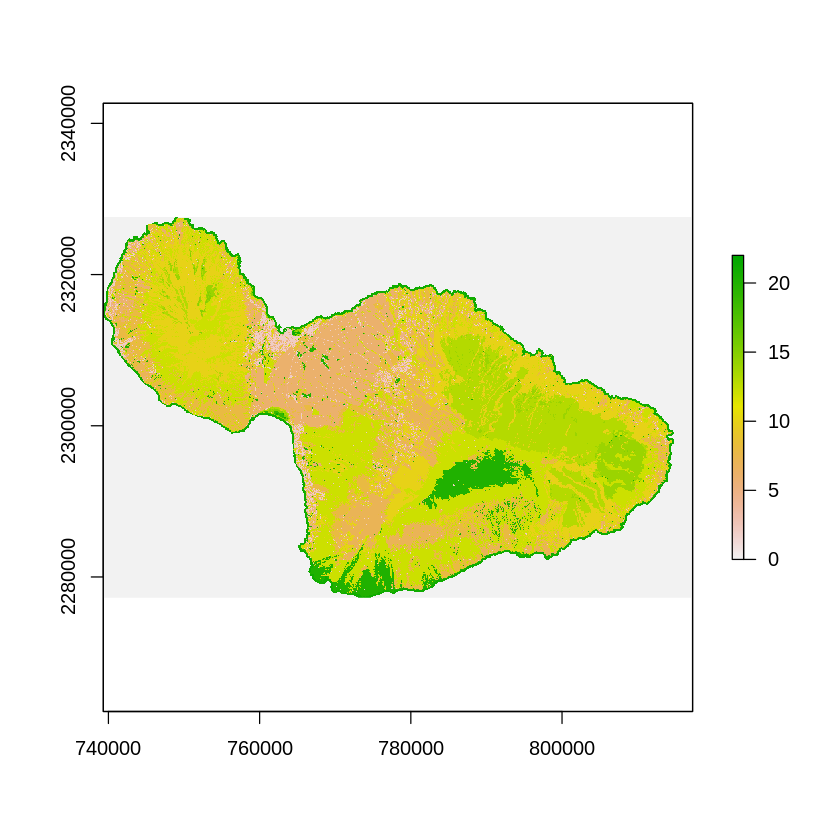

In [9]:
ccap_raster%>% plot

In [10]:
# # Stack all three layers into one
# stack_all <- stack(ls_2000, ls_2001, ls_2002)

# # Define the output file path
# output_path <- '/content/Lanai/Lanai_2000_2002.tif'

# # Write the stacked raster to a new .tif file
# writeRaster(stack_all, filename = output_path, format = 'GTiff')

# # Check the new file
# stack_all


In [11]:
# stack_all%>% plot

In [12]:
nrow(ccap_raster)
ncol(ccap_raster)
nlayers(ccap_raster)
dim(ccap_raster)

[1] 20986

[1] 32476

[1] 1

[1] 20986 32476     1

In [13]:
nrow(ls_raster)
ncol(ls_raster)
nlayers(ls_raster)
dim(ls_raster)

[1] 1863

[1] 2805

[1] 7

[1] 1863 2805    7

In [14]:
ls_raster_extended <- extend(ls_raster, projectExtent(ccap_raster, ls_raster), value=NA)

In [15]:
ls_raster_extended

class      : RasterBrick 
dimensions : 1863, 2847, 5303961, 7  (nrow, ncol, ncell, nlayers)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -156.7151, -155.9479, 20.54869, 21.05076  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : memory
names      :    Blue,   Green,     Red,     NIR,   SWIR1,   SWIR2, elevation 
min values :     -14,      77,       6,     442,     275,     162,       -29 
max values : 16951.0, 17054.0, 18155.0,  6389.5,  5223.0,  4624.0,    3051.0 


In [27]:
ncol(ccap_raster)

nrow(ccap_raster)


y_end <- c(seq(1,ccap_raster %>% nrow,1024),nrow(ccap_raster))[-1]
x_end <- c(seq(1,ccap_raster %>% ncol,1024),ncol(ccap_raster))[-1]

extract_grid <- expand.grid(x_end,y_end) %>% data.table

names(extract_grid) <- c('x_end','y_end')

extract_grid$x_org <- extract_grid$x_end - 1024
extract_grid$y_org <- extract_grid$y_end - 1024

extract_grid$id <- 1:nrow(extract_grid)

[1] 32476

[1] 20986

In [28]:
y_end
x_end

[1]  1025  2049  3073  4097  5121  6145  7169  8193  9217 10241 11265 12289
[13] 13313 14337 15361 16385 17409 18433 19457 20481 20986

[1]  1025  2049  3073  4097  5121  6145  7169  8193  9217 10241 11265 12289
[13] 13313 14337 15361 16385 17409 18433 19457 20481 21505 22529 23553 24577
[25] 25601 26625 27649 28673 29697 30721 31745 32476

In [31]:
extract_grid

x_end,y_end,x_org,y_org,id
<dbl>,<dbl>,<dbl>,<dbl>,<int>
1025,1025,1,1,1
2049,1025,1025,1,2
3073,1025,2049,1,3
4097,1025,3073,1,4
5121,1025,4097,1,5
6145,1025,5121,1,6
7169,1025,6145,1,7
8193,1025,7169,1,8
9217,1025,8193,1,9


In [18]:
dir.create('/content/Maui_exports')

In [19]:
new_folder_path <- "/content/Maui_exports/Maui_Images"
new_folder_path2 <- "/content/Maui_exports/Maui_Labels"
# Use dir.create to create the new folder
dir.create(new_folder_path, showWarnings = FALSE)

# Check if the folder was created successfully
if (file.exists(new_folder_path)) {
  cat("Folder created:", new_folder_path, "\n")
} else {
  cat("Failed to create folder:", new_folder_path, "\n")
}


# Use dir.create to create the new folder
dir.create(new_folder_path2, showWarnings = FALSE)
# Check if the folder was created successfully
if (file.exists(new_folder_path2)) {
  cat("Folder created:", new_folder_path2, "\n")
} else {
  cat("Failed to create folder:", new_folder_path2, "\n")
}

Folder created: /content/Maui_exports/Maui_Images 
Folder created: /content/Maui_exports/Maui_Labels 


In [ ]:
# extract_grid

In [39]:
result_dt <-
1:nrow(extract_grid) %>% lapply(function(x){

  nrow <- 0
  ncol <- 0
  i <- 0
  while(nrow !=1024 | ncol != 1024){
    i <- i + 1
    # Calculate the geographic coordinates for the cropping extent
    xmin <- xFromCol(ccap_raster, extract_grid[x,]$x_org) + rnorm(1)*.01*2.4
    xmax <- xFromCol(ccap_raster, extract_grid[x,]$x_end) + rnorm(1)*.01*2.4
    ymin <- yFromRow(ccap_raster, extract_grid[x,]$y_end) + rnorm(1)*.01*2.4 # Note row_max as raster origin is top-left
    ymax <- yFromRow(ccap_raster, extract_grid[x,]$y_org) + rnorm(1)*.01*2.4 # Note row_min as raster origin is top-left

    e <- extent(xmin, xmax, ymin, ymax)

    ccap_cropped_raster <- crop(ccap_raster, e)

    nrow <- nrow(ccap_cropped_raster)
    ncol <- ncol(ccap_cropped_raster)


    # print(dim(ccap_cropped_raster))
    if(i>1000){return('failed to converge')}
    }

  ls_cropped_raster <- crop(ls_raster_extended, projectExtent(ccap_cropped_raster,ls_raster))

  ls_resampled_raster <- projectRaster(ls_cropped_raster,ccap_cropped_raster)
  print(ls_resampled_raster)
  pixel_table <- (table(values(ccap_cropped_raster))/ncell(ccap_cropped_raster)) %>% data.table

  names(pixel_table) <- c('label','percent')

  out_dt <- data.table(extract_grid[x,],xmin = xmin,xmax =xmax,ymin= ymin,ymax, pixel_table)

  if(ls_resampled_raster %>% nrow ==1024 & ls_resampled_raster %>% ncol ==1024 & ccap_cropped_raster%>% nrow ==1024 & ccap_cropped_raster%>% ncol ==1024){
    ls_resampled_raster %>%
    writeRaster(., paste("/content/Maui_exports/Maui_Images/",extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)

    ccap_cropped_raster %>%
    writeRaster(., paste("/content/Maui_exports/Maui_Labels/",extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)
  }else(print('uh oh'))

  return(out_dt)
})
result_dt[ result_dt %>% lapply(function(x){is.data.table(x)}) %>% unlist] %>% rbindlist %>%
fwrite("/content/Maui_exports/Maui_oneYear.csv") # /content/Maui10/


In [32]:
result_dt[ result_dt %>% lapply(function(x){is.data.table(x)}) %>% unlist] %>% rbindlist %>%
fwrite("content/Maui_oneYear.csv")

ERROR: ignored

In [33]:
zip(zipfile = 'content/Maui_oneYear.zip', files = c("/content/Maui_exports"))

Warning message in fix_absolute_paths(data$key):
“Dropping leading `/` from paths, all paths in a zip file must be relative paths.”


ERROR: ignored

In [40]:
zip(zipfile = "/content/Maui_exports.zip",
    files = c("/content/Maui_exports/Maui_Images",
              "/content/Maui_exports/Maui_Labels",
              "/content/Maui_exports/Maui_oneYear.csv"))




Warning message in fix_absolute_paths(data$key):
“Dropping leading `/` from paths, all paths in a zip file must be relative paths.”


In [42]:
# revised_trainingdata https://drive.google.com/drive/folders/1bHbapyUMII5K7Ycik75RhO6wMZV6vfvE?usp=drive_link
drive_upload(media = "/content/Maui_exports.zip", path = as_id("1bHbapyUMII5K7Ycik75RhO6wMZV6vfvE"))

Auto-refreshing stale OAuth token.

Local file:

• /content/Maui_exports.zip

Uploaded into Drive file:

• Maui_exports.zip <id: 1Tl6HJsC5yssdSoyjfgwVpL1jRQ-3MqT->

With MIME type:

• application/zip

